# **Loading Data**

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

# Load the CIFAR-10 dataset
(xTrain, yTrain), (xTest, yTest) = cifar10.load_data()

# Basic information about the dataset
print("Number of training images:", xTrain.shape[0])
print("Number of testing images:", xTest.shape[0])
print("Number of classes:", len(set(yTrain.flatten())))
print("Shape of an image:", xTrain.shape[1:])

# Display the number of data entries for each class in the training dataset
import numpy as np

unique, counts = np.unique(yTrain, return_counts=True)
classCounts = dict(zip(unique, counts))
print("Number of data entries per class in the training set:", classCounts)


170498071/170498071 [==============================] - 5s 0us/step
Number of training images: 50000
Number of testing images: 10000
Number of classes: 10
Shape of an image: (32, 32, 3)
Number of data entries per class in the training set: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}


In [2]:
boxTrain = tf.convert_to_tensor([[0.5, 0.5, 1.0, 1.0] for _ in range(yTrain.shape[0])], dtype=tf.float32)
boxTest = tf.convert_to_tensor([[0.5, 0.5, 1.0, 1.0] for _ in range(yTest.shape[0])], dtype=tf.float32)

# **Prepare the Model**

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanSquaredError

In [5]:
# Define the CNN model
inputLayer = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputLayer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
classOutput = Dense(10, activation='softmax', name='class_output')(x)  # Classification output
boxOutput = Dense(4, activation='sigmoid', name='box_output')(x)  # Bounding box output

model = Model(inputs=inputLayer, outputs=[classOutput, boxOutput])

# Losses
classification_loss = SparseCategoricalCrossentropy()
bbox_loss = MeanSquaredError()

# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(optimizer=optimizer, loss={'class_output': classification_loss, 'box_output': bbox_loss},
              metrics={'class_output': 'accuracy', 'box_output': 'mse'})

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 32)           896       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 16, 16, 64)           18496     ['max_pooling2d[0][0]']   

# **Train  Model**

In [ ]:
model.fit(xTrain, {'class_output': yTrain, 'box_output': boxTrain},
          validation_data=(xTest, {'class_output': yTest, 'box_output': boxTest}),
          epochs=10, batch_size=64)

In [9]:
model.evaluate(xTest, {'class_output': yTest, 'box_output': boxTest})

313/313 [==============================] - 8s 26ms/step - loss: 1.0120 - class_output_loss: 1.0120 - box_output_loss: 2.3903e-05 - class_output_accuracy: 0.6792 - box_output_mse: 2.3903e-05


[1.0119901895523071,
 1.0119659900665283,
 2.3902937755337916e-05,
 0.6791999936103821,
 2.3902937755337916e-05]

313/313 [==============================] - 15s 48ms/step


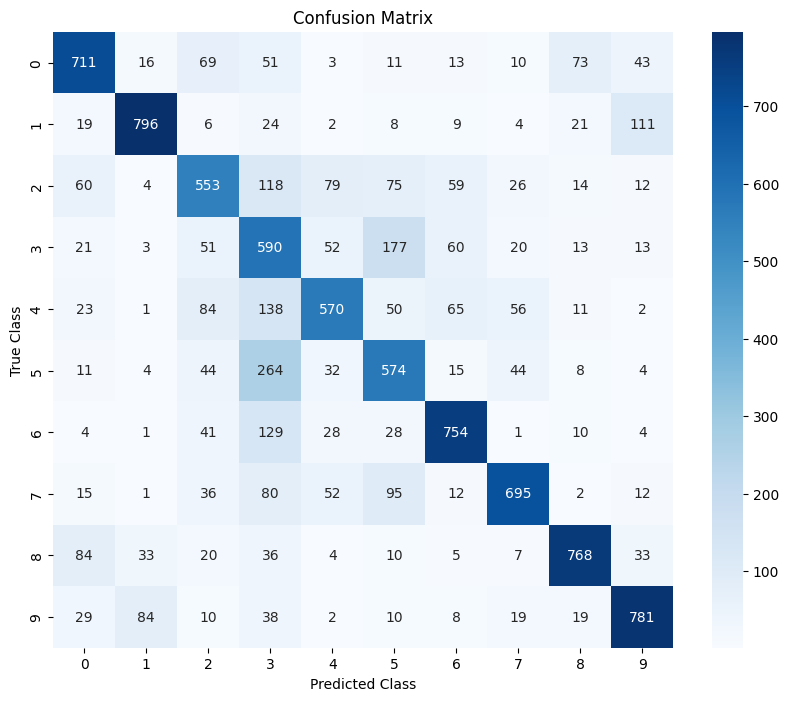

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict classes on the test data
predictions = model.predict(xTest)
predicted_classes = np.argmax(predictions[0], axis=1)  # Extract predicted classes

# True classes
true_classes = yTest.flatten()

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()


# **Use the Trained Model for Detecting Objects**

1/1 [==============================] - 0s 93ms/step


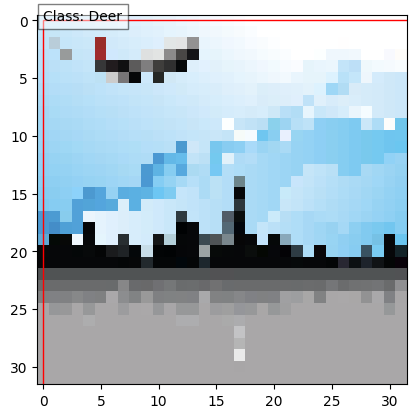

Class 4 corresponds to: Deer


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# CIFAR-10 class labels
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Load and preprocess the image
def load_and_preprocess_image(img_path, target_size=(32, 32)):
    img = image.load_img(img_path, target_size=target_size)  # Resize the image to 32x32 for model input
    img_array = image.img_to_array(img)  # Convert the image to a numpy array
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0  # Normalize and add batch dimension
    return img, img_array_expanded

img_path = "/content/sample_data/Screenshot 2024-04-24 at 10.51.24.png"
original_img, processed_img = load_and_preprocess_image(img_path)

# Predict using the trained model
predictions = model.predict(processed_img)
predicted_class_index = np.argmax(predictions[0], axis=1)[0]  # Get the index of the class with the highest probability
predicted_class_label = labels[predicted_class_index]  # Get the label from the labels list
predicted_bbox = predictions[1][0]  # Get the predicted bounding box

# Plotting
fig, ax = plt.subplots(1)
ax.imshow(original_img)

# Bounding box: convert normalized coordinates to pixel coordinates for visualization
x_center, y_center, width, height = predicted_bbox
x = (x_center - width / 2) * original_img.width
y = (y_center - height / 2) * original_img.height
rect = patches.Rectangle((x, y), width * original_img.width, height * original_img.height, linewidth=1, edgecolor='r', facecolor='none')

ax.add_patch(rect)
ax.text(x, y, f'Class: {predicted_class_label}', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

# Printing the class label for class 4
print("Class 4 corresponds to:", labels[4])


# **Evalution of the model**

In [15]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Get model predictions for the test set
y_pred_prob = model.predict(xTest)[0]  # Assuming the first output are the class probabilities

# Binarize the labels for all classes
y_true_bin = label_binarize(yTest, classes=[i for i in range(10)])

# Calculate average precision for each class
average_precision = {}
for i in range(10):
    average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])

# Calculate mean Average Precision (mAP)
mean_ap = np.mean(list(average_precision.values()))
print(f"Mean Average Precision (mAP): {mean_ap}")


313/313 [==============================] - 10s 31ms/step
Mean Average Precision (mAP): 0.751404666265465


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(image_batch, predictions, num_images=5):
    # Assuming the first output is class probabilities and each prediction corresponds to a batch item
    pred_probs = predictions[0]  # This should be the class probabilities output
    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i, ax in enumerate(axes):
        img = image_batch[i]  # Access the i-th image
        pred_class = np.argmax(pred_probs[i])  # Get the index of the max logit for the i-th image in the batch
        pred_confidence = np.max(pred_probs[i])  # Confidence as max probability for the i-th image

        ax.imshow(img / 255.0)  # Assuming the image needs to be normalized for display
        ax.set_title(f'Class: {labels[pred_class]} \nConfidence: {pred_confidence:.2f}')
        ax.axis('off')
    plt.show()

# Call the function with the actual data
visualize_predictions(xTest[:10], predictions, num_images=10)


# **Extra Credit Opportunities**

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout


In [21]:
from tensorflow.keras.applications.vgg16 import VGG16

# Load VGG16 pre-trained on ImageNet without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers on top of VGG16
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(10, activation='softmax')(x)  # Assuming 10 classes

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 1s 0us/step


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data augmentation configuration
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Example: Apply the data augmentation in model training
# Assuming xTrain and yTrain are your training data and labels
train_generator = datagen.flow(xTrain, yTrain, batch_size=32)


In [23]:
from tensorflow.keras.layers import BatchNormalization

# Example of a different architecture
inputs = Input(shape=(32, 32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

model2 = Model(inputs=inputs, outputs=output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Hyperparameter tuning (example using a learning rate schedule)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Assuming data augmentation is set up as previously shown
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare the model checkpoint and early stopping callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Fit the model using a generator, which is useful for data augmentation
history = model2.fit(
    datagen.flow(xTrain, yTrain, batch_size=32),  # Training data generator
    epochs=50,  # Number of epochs to train
    validation_data=(xTrain, yTrain),  # Validation data
    callbacks=[checkpoint, early_stopping],  # Callbacks for saving the best model and early stopping
    verbose=1
)

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
